# Connect to Google Drive
This section can be skipped if you prefer to edit generated image.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Save a backup

import os
import shutil
from datetime import datetime

def backup_dataset(source_dir, backup_dir):
    """
    Creates a complete backup of the dataset directory
    """
    # Create timestamp for backup folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_path = os.path.join(backup_dir, f"Dataset_backup_{timestamp}")

    try:
        # Check if source exists
        if not os.path.exists(source_dir):
            print(f"Error: Source directory '{source_dir}' does not exist!")
            return False

        # Create backup directory if it doesn't exist
        os.makedirs(backup_dir, exist_ok=True)

        # Count total files for progress tracking
        total_files = sum([len(files) for _, _, files in os.walk(source_dir)])
        print(f"Starting backup of {total_files} files...")
        print(f"Source: {source_dir}")
        print(f"Destination: {backup_path}")

        # Copy the entire directory tree
        shutil.copytree(source_dir, backup_path)

        # Verify backup
        backup_files = sum([len(files) for _, _, files in os.walk(backup_path)])

        if backup_files == total_files:
            print(f"\n✓ Backup completed successfully!")
            print(f"  Total files backed up: {backup_files}")
            print(f"  Backup location: {backup_path}")

            # Calculate backup size
            backup_size = sum(os.path.getsize(os.path.join(dirpath, filename))
                            for dirpath, _, filenames in os.walk(backup_path)
                            for filename in filenames)
            print(f"  Backup size: {backup_size / (1024**2):.2f} MB")
        else:
            print(f"\n⚠ Warning: File count mismatch!")
            print(f"  Source files: {total_files}")
            print(f"  Backed up files: {backup_files}")

        return True

    except Exception as e:
        print(f"\n✗ Backup failed: {e}")
        return False

# Run the backup
source_path = '/content/drive/MyDrive/itrc_augmentation/Dataset/'
backup_path = '/content/drive/MyDrive/backup/'

backup_dataset(source_path, backup_path)

Starting backup of 1074 files...
Source: /content/drive/MyDrive/itrc_augmentation/Dataset/
Destination: /content/drive/MyDrive/backup/Dataset_backup_20250904_220655


KeyboardInterrupt: 

In [ ]:
import os
from PIL import Image
from collections import Counter

def convert_all_images_to_png(base_directory, remove_originals=False):
    converted_count = 0
    skipped_count = 0
    error_count = 0
    already_png_count = 0
    file_extensions = Counter()
    person_stats = {}

    # First pass - count all files and their extensions
    total_files = 0
    for person_dir in os.listdir(base_directory):
        person_path = os.path.join(base_directory, person_dir)
        if os.path.isdir(person_path):
            person_file_count = 0
            for file in os.listdir(person_path):
                if os.path.isfile(os.path.join(person_path, file)):
                    total_files += 1
                    person_file_count += 1
                    ext = os.path.splitext(file)[1].lower()
                    file_extensions[ext] += 1
            person_stats[person_dir] = {'total': person_file_count, 'converted': 0, 'already_png': 0, 'errors': 0}

    print(f"Found {total_files} total files across {len(person_stats)} person directories")
    print(f"File extensions found: {dict(file_extensions)}")
    print("-" * 50)

    # Second pass - convert all files
    for person_dir in os.listdir(base_directory):
        person_path = os.path.join(base_directory, person_dir)
        if not os.path.isdir(person_path):
            continue

        print(f"\nProcessing person: {person_dir}")

        for file in os.listdir(person_path):
            img_path = os.path.join(person_path, file)

            # Skip if not a file
            if not os.path.isfile(img_path):
                continue

            # Skip if already PNG
            if file.lower().endswith('.png'):
                already_png_count += 1
                person_stats[person_dir]['already_png'] += 1
                continue

            try:
                Image.MAX_IMAGE_PIXELS = None
                img = Image.open(img_path)

                # Handle different image modes
                if img.mode in ('RGBA', 'LA', 'P'):
                    if img.mode == 'RGBA' or 'transparency' in img.info:
                        img = img.convert('RGBA')
                    else:
                        img = img.convert('RGB')
                else:
                    img = img.convert('RGB')

                new_filename = os.path.splitext(file)[0] + '.png'
                new_path = os.path.join(person_path, new_filename)

                img.save(new_path, 'PNG', optimize=True)

                # Confirm save
                if os.path.exists(new_path):
                    print(f'  Converted: {file} -> {new_filename}')
                    converted_count += 1
                    person_stats[person_dir]['converted'] += 1

                    if remove_originals:
                        os.remove(img_path)
                        print(f'  Removed original: {file}')
                else:
                    print(f'  Failed to save: {new_filename}')
                    error_count += 1
                    person_stats[person_dir]['errors'] += 1

            except Exception as e:
                print(f'  Error converting {file}: {e}')
                error_count += 1
                person_stats[person_dir]['errors'] += 1

    # Final count verification
    print("\n" + "=" * 50)
    print(f"Conversion Summary:")
    print(f"  Already PNG: {already_png_count}")
    print(f"  Converted: {converted_count}")
    print(f"  Errors: {error_count}")
    print(f"  Total processed: {already_png_count + converted_count + error_count}")

    # Show per-person statistics
    print(f"\nPer-person statistics:")
    for person, stats in sorted(person_stats.items()):
        total_png = stats['already_png'] + stats['converted']
        print(f"  {person}: {total_png} PNG files (was {stats['already_png']} PNG, converted {stats['converted']}, errors {stats['errors']})")

    # Count final PNG files
    final_png_count = 0
    for person_dir in os.listdir(base_directory):
        person_path = os.path.join(base_directory, person_dir)
        if os.path.isdir(person_path):
            for file in os.listdir(person_path):
                if file.lower().endswith('.png') and os.path.isfile(os.path.join(person_path, file)):
                    final_png_count += 1

    print(f"\nFinal PNG count across all directories: {final_png_count}")

    if final_png_count == 2062:
        print("✓ Success! All 2062 images are now in PNG format.")
    else:
        print(f"✗ Warning: Expected 2062 PNG files, but found {final_png_count}")

        # Additional diagnostics
        if not remove_originals:
            all_images = 0
            for person_dir in os.listdir(base_directory):
                person_path = os.path.join(base_directory, person_dir)
                if os.path.isdir(person_path):
                    for file in os.listdir(person_path):
                        file_path = os.path.join(person_path, file)
                        if os.path.isfile(file_path):
                            try:
                                Image.open(file_path).verify()
                                all_images += 1
                            except:
                                pass
            print(f"Total valid images in all directories: {all_images}")

    return converted_count

# Usage
base_directory = "/content/drive/MyDrive/itrc_augmentation/Dataset/"
convert_all_images_to_png(base_directory, remove_originals=False)

Converted: /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071015.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071015.png
Converted: /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071013.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071013.png
Converted: /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071009.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071009.png
Converted: /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071044.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071044.png
Converted: /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071036.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071036.png
Converted: /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071023.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/51071023.png
Converted: /content/drive/MyDrive/itrc_a

In [ ]:
from PIL import Image, ImageFile
import os

# Problematic image paths
problem_images = [
    '/content/drive/MyDrive/itrc_augmentation/Dataset/20_satar_hashemi/51201026.jpg',
    '/content/drive/MyDrive/itrc_augmentation/Dataset/11_bokaei/51111012.jpg',
    '/content/drive/MyDrive/itrc_augmentation/Dataset/12_moein/51121021.JPG'
]

# Enable loading truncated images for corrupted one
ImageFile.LOAD_TRUNCATED_IMAGES = True

for img_path in problem_images:
    try:
        # Temporarily disable pixel limit only for large images
        Image.MAX_IMAGE_PIXELS = None
        img = Image.open(img_path)

        # Convert to RGB or RGBA depending on transparency
        if img.mode in ('RGBA', 'LA', 'P'):
            if img.mode == 'RGBA' or 'transparency' in img.info:
                img = img.convert('RGBA')
            else:
                img = img.convert('RGB')
        else:
            img = img.convert('RGB')

        # Save back to PNG in the same folder
        base_name = os.path.splitext(img_path)[0]
        new_path = base_name + '.png'
        img.save(new_path, 'PNG', optimize=True)
        print(f'Converted {img_path} -> {new_path}')

        # Reset pixel limit if desired (can omit if only running for these)
        Image.MAX_IMAGE_PIXELS = 178956970

    except Exception as e:
        print(f'Error processing {img_path}: {e}')


Converted /content/drive/MyDrive/itrc_augmentation/Dataset/20_satar_hashemi/51201026.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/20_satar_hashemi/51201026.png
Converted /content/drive/MyDrive/itrc_augmentation/Dataset/11_bokaei/51111012.jpg -> /content/drive/MyDrive/itrc_augmentation/Dataset/11_bokaei/51111012.png
Converted /content/drive/MyDrive/itrc_augmentation/Dataset/12_moein/51121021.JPG -> /content/drive/MyDrive/itrc_augmentation/Dataset/12_moein/51121021.png


In [ ]:
import os
from PIL import Image

def remove_non_png_images(base_directory):
    removed_count = 0
    error_count = 0
    kept_png_count = 0
    person_stats = {}

    print(f"Scanning directory: {base_directory}")
    print("WARNING: This will permanently delete all non-PNG files!")
    print("-" * 50)

    # First, count what we have
    for person_dir in os.listdir(base_directory):
        person_path = os.path.join(base_directory, person_dir)
        if os.path.isdir(person_path):
            person_stats[person_dir] = {'png': 0, 'non_png': 0, 'removed': 0, 'errors': 0}

            for file in os.listdir(person_path):
                file_path = os.path.join(person_path, file)
                if os.path.isfile(file_path):
                    if file.lower().endswith('.png'):
                        person_stats[person_dir]['png'] += 1
                    else:
                        person_stats[person_dir]['non_png'] += 1

    # Show what will be removed
    total_non_png = sum(stats['non_png'] for stats in person_stats.values())
    total_png = sum(stats['png'] for stats in person_stats.values())

    print(f"\nFound:")
    print(f"  PNG files: {total_png}")
    print(f"  Non-PNG files to remove: {total_non_png}")

    if total_non_png == 0:
        print("\nNo non-PNG files found. Nothing to remove.")
        return 0

    # Remove non-PNG files
    print(f"\nRemoving {total_non_png} non-PNG files...")
    print("-" * 50)

    for person_dir in os.listdir(base_directory):
        person_path = os.path.join(base_directory, person_dir)
        if not os.path.isdir(person_path):
            continue

        if person_stats[person_dir]['non_png'] > 0:
            print(f"\nProcessing {person_dir} ({person_stats[person_dir]['non_png']} non-PNG files):")

        for file in os.listdir(person_path):
            file_path = os.path.join(person_path, file)

            # Skip if not a file
            if not os.path.isfile(file_path):
                continue

            # Keep PNG files
            if file.lower().endswith('.png'):
                kept_png_count += 1
                continue

            # Verify it's actually an image before removing
            try:
                # Try to open it as an image to confirm it's an image file
                Image.open(file_path).verify()

                # Remove the file
                os.remove(file_path)
                print(f"  Removed: {file}")
                removed_count += 1
                person_stats[person_dir]['removed'] += 1

            except Exception as e:
                print(f"  Error with {file}: {e}")
                error_count += 1
                person_stats[person_dir]['errors'] += 1

    # Final summary
    print("\n" + "=" * 50)
    print("Removal Summary:")
    print(f"  PNG files kept: {kept_png_count}")
    print(f"  Non-PNG files removed: {removed_count}")
    print(f"  Errors: {error_count}")

    # Per-person summary
    print(f"\nPer-person summary:")
    for person, stats in sorted(person_stats.items()):
        if stats['non_png'] > 0:
            print(f"  {person}: Kept {stats['png']} PNG, removed {stats['removed']} non-PNG, {stats['errors']} errors")

    # Final count
    final_count = 0
    for person_dir in os.listdir(base_directory):
        person_path = os.path.join(base_directory, person_dir)
        if os.path.isdir(person_path):
            final_count += len([f for f in os.listdir(person_path)
                              if os.path.isfile(os.path.join(person_path, f))])

    print(f"\nTotal files remaining: {final_count}")

    return removed_count

# Usage
base_directory = "/content/drive/MyDrive/itrc_augmentation/Dataset/"
removed = remove_non_png_images(base_directory)

Scanning directory: /content/drive/MyDrive/itrc_augmentation/Dataset/
--------------------------------------------------

Found:
  PNG files: 1072
  Non-PNG files to remove: 990

Removing 990 non-PNG files...
--------------------------------------------------

Processing 7_khansari (51 non-PNG files):
  Removed: 51072001.jpg
  Removed: 51072101.jpg
  Removed: 51072201.jpg
  Removed: 51072301.jpg
  Removed: 51072401.jpg
  Removed: 51072501.jpg
  Removed: 51071032.jpg
  Removed: 51071018.jpg
  Removed: 51071019.jpg
  Removed: 51071038.jpg
  Removed: 51071028.jpg
  Removed: 51071039.jpg
  Removed: 51071013.jpg
  Removed: 51071007.jpg
  Removed: 51071044.jpg
  Removed: 51071036.jpg
  Removed: 51071009.jpg
  Removed: 51071027.jpg
  Removed: 51071023.jpg
  Removed: 51071043.jpg
  Removed: 51071015.jpg
  Removed: 51071031.jpg
  Removed: 51071016.jpg
  Removed: 51071030.jpg
  Removed: 51071005.jpg
  Removed: 51071001.jpg
  Removed: 51071008.jpg
  Removed: 51071014.jpg
  Removed: 51071045.jpg
 

In [ ]:
import os

dataset_root = "/content/drive/MyDrive/itrc_augmentation/Dataset/"

def remove_uppercase_duplicates(root_dir):
    removed_files = []
    for person_id in os.listdir(root_dir):
        person_path = os.path.join(root_dir, person_id)
        if not os.path.isdir(person_path):
            continue

        # Normalize by filename stem (ignoring extension case)
        seen = {}
        for file_name in os.listdir(person_path):
            file_path = os.path.join(person_path, file_name)
            name, ext = os.path.splitext(file_name)

            if ext.lower() not in [".png", ".jpg", ".jpeg"]:
                continue  # skip non-images

            key = name.lower()  # unique identifier for the image
            if key not in seen:
                seen[key] = (file_name, ext)
            else:
                # If duplicate found, prefer the lowercase extension version
                if ext.isupper():
                    os.remove(file_path)
                    removed_files.append(file_path)
                else:
                    # If lowercase version comes later, remove the earlier uppercase one
                    prev_file, prev_ext = seen[key]
                    if prev_ext.isupper():
                        prev_path = os.path.join(person_path, prev_file)
                        os.remove(prev_path)
                        removed_files.append(prev_path)
                        seen[key] = (file_name, ext)

    print(f"🗑️ Removed {len(removed_files)} uppercase-extension duplicates")
    return removed_files

# Run cleanup
removed = remove_uppercase_duplicates(dataset_root)


🗑️ Removed 7 uppercase-extension duplicates


In [ ]:
#@ install roboflow

!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
!pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python
!pip install opencv-python opencv-contrib-python


Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
#@title Upload dataset to roboflow for labeling


# Import Roboflow and initialize with your API key
from roboflow import Roboflow
rf = Roboflow(api_key="zxMdI8fDJc3Zj8p1bXyX")

# Access your workspace
workspace = rf.workspace("cracking")

# Dataset path in Google Drive
dataset_path = '/content/drive/MyDrive/itrc_augmentation/Dataset/'

# Upload dataset folder with CC BY 4.0 license
upload_response = workspace.upload_dataset(
    dataset_path,
    "faces-2xoys",
    num_workers=10,
    project_license="CC BY 4.0",
    project_type="object-detection"
)

print("Upload response:", upload_response)

loading Roboflow workspace...
loading Roboflow project...


100%|██████████| 1074/1074 [00:00<00:00, 467484.69it/s]


Uploading to existing project cracking/faces-2xoys
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101008.png (zsj65aaq2SEIrUkJmlK2) [0.6s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101002.png (OZ0om8LYJAydU9qgdrqQ) [17.7s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101009.png (eZahrnQZ3TmXEoGV7FEZ) [18.3s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101010.png (644HCUFdl5zmfTJffAIo) [18.7s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101001.png (jGAZgKcZXRaXmnBshtdB) [19.0s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101011.png (jJacDc1diSvLkY9tFFV7) [20.9s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101004.png (9pdwkX1WjeLcknT1oPoO) [23.2s]
[UPLOADED] /content/drive/MyDrive/itrc_augmentation/Dataset/10_yazdanian/51101007.png (DIYnQBIBI81Vd3dSwD3p) [23.6s]
[UPLOADED] /co

In [ ]:
import os

# Path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/itrc_augmentation/Dataset/'

def count_all_files(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

total_files = count_all_files(dataset_path)
print(f"Total files (images) in dataset folder: {total_files}")


Total files (images) in dataset folder: 1067


In [4]:
#@title Setup (may take a few minutes)
#@title After you run this cell for the first time and get error you need to edit python core code and change imp to importlib

import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force


%cd
%cd /content/

! pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
! git clone https://github.com/orpatashnik/StyleCLIP
!pip install insightface onnxruntime

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2
%matplotlib inline


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0+rocm5.7, 2.2.1, 2.2.1+cpu, 2.2.1+cpu.cxx11.abi, 2.2.1+cu118, 2.2.1+cu121, 2.2.1+rocm5.6, 2.2.1+rocm5.7, 2.2.2, 2.2.2+cpu, 2.2.2+cpu.cxx11.abi, 2.2.2+cu118, 2.2.2+cu121, 2.2.2+rocm5.6, 2.2.2+rocm5.7, 2.3.0, 2.3.0+cpu, 2.3.0+cpu.cxx11.abi, 2.3.0+cu118, 2.3.0+cu121, 2.3.0+rocm5.7, 2.3.0+rocm6.0, 2.3.1, 2.3.1+cpu, 2.3.1+cpu.cxx11.abi, 2.3.1+cu118, 2.3.1+cu121, 2.3.1+rocm5.7, 2.3.1+rocm6.0, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.7.1+cu110
fatal: destination path 'encoder4editing' already exists and is not an empty directory.
--2025-09-06 06:19:51--  https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
Resolving github.com (github.com)... 20.205.243.16

# Select dataset
If you want to use another dataset, please restart runtime. currently, we only support ffhq.

In [5]:
dataset_name='ffhq' #@param ['ffhq'] {allow-input: true}
# input dataset name

%cd
%cd /content/StyleCLIP/global_torch/

if not os.path.isfile('./model/'+dataset_name+'.pkl'):
        url='https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/'
        name='stylegan2-'+dataset_name+'-config-f.pkl'
        os.system('wget ' +url+name + '  -P  ./model/')
        os.system('mv ./model/'+name+' ./model/'+dataset_name+'.pkl')


# input prepare data
import clip
from manipulate import Manipulator
from StyleCLIP import GetDt,GetBoundary


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device,jit=False)

network_pkl='./model/'+dataset_name+'.pkl'
device = torch.device('cuda')
M=Manipulator()
M.device=device
G=M.LoadModel(network_pkl,device)
M.G=G
M.SetGParameters()
num_img=100_000
M.GenerateS(num_img=num_img)
M.GetCodeMS()
np.set_printoptions(suppress=True)

file_path='./npy/'+dataset_name+'/'
fs3=np.load(file_path+'fs3.npy')


/root
/content/StyleCLIP/global_torch


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 64.2MiB/s]


name:conv1_resolution_4 Resolution: 4, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_4 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_8 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_16 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_32 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_64 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_128 Resolution: 128, InC: 512, OutC:256, w_dim: 512
name:conv1_resol

W0906 06:23:40.125000 1274 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0906 06:23:40.125000 1274 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.


Define Augmentation Codes

In [ ]:
from enum import Enum

class AUGCODES(Enum):
    BASE = 10
    MAX_BRIGHTNESS = 11
    MIN_BRIGHTNESS = 12
    BLUR = 13
    RESIZE = 14
    ROTATE = 15
    JUNGLE_BG = 16
    COLORFUL1_BG = 17
    COLORFUL2_BG = 18
    COLORFUL3_BG = 19

    CHANGE_HAIR_COLOR = 20
    CHANGE_HAIR_STYLE = 21
    CHANGE_FACIAL_EXPRESSION = 22
    CHANGE_AGE = 23
    ADD_ACCESSORIES = 24

    EYE_FEATURE = 25
    EYE_COLOR = 26
    SKIN_TONE = 27
    MAKEUP = 28


In [6]:
#@title e4e setup
#@ e4e setup
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Downloading...
From (original): https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
From (redirected): https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P&confirm=t&uuid=e5c21a47-7b1b-4433-bbeb-3af34144ef16
To: /content/encoder4editing/e4e_ffhq_encode.pt
100%|██████████| 1.20G/1.20G [00:20<00:00, 59.4MB/s]


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


--2025-09-06 06:24:42--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-09-06 06:24:43--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.2MB/s    in 5.2s    

2025-09-06 06:24:49 (11.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


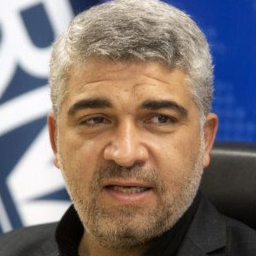

In [7]:
#@title Align image
image_dir = "/content/drive/MyDrive/itrc_augmentation/Dataset/7_khansari/" #@param {type: "string"}
image_name = "51071001.png" #@param {type: "string"}
image_path = image_dir + image_name
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

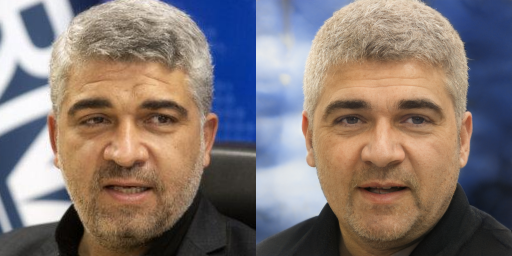

In [8]:
#@title Invert the image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)




# Choose Image Index
Relevant only when editing generated image


In [9]:
img_index =  1#@param {type:"number"}

# Choose Mode (and show input image)
Run for both real and generated image

Setting up PyTorch plugin "upfirdn2d_plugin"... 

W0906 06:24:58.719000 1274 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0906 06:24:58.719000 1274 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.


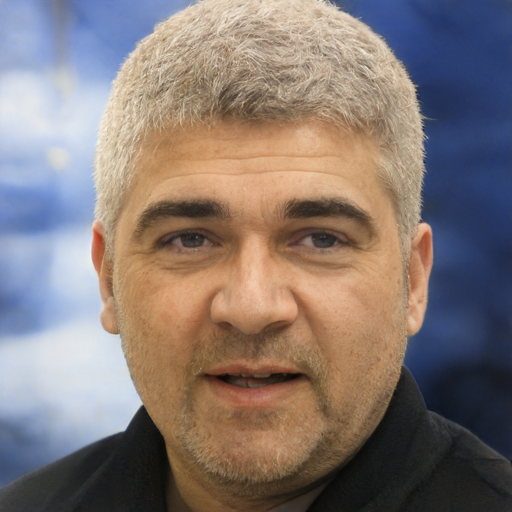

In [10]:
mode='real image' #@param ['real image', 'generated image']

if mode == 'real image':
  img_index = 0
  latents=torch.load('/content/encoder4editing/latents.pt')
  dlatents_loaded=M.G.synthesis.W2S(latents)

  img_indexs=[img_index]
  dlatents_loaded=M.S2List(dlatents_loaded)

  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
elif mode == 'generated image':
  img_indexs=[img_index]
  dlatents_loaded=M.S2List(dlatents_loaded)
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp)
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original


# input text description
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |


In [11]:
neutral='face with eyes' #@param {type:"string"}
target='face with Asian skin tone' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.4126


# modify manipulation strength (alpha) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

In [ ]:
!rm -rf ~/.cache/torch_extensions/


In [ ]:
!apt install ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ninja-build is already the newest version (1.10.1-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import os

def delete_non_yy_10_images(root_dir):
    count_deleted = 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Check if yy (chars 4 and 5) is "10"
                if filename[4:6] != "10":
                    file_path = os.path.join(dirpath, filename)
                    try:
                        os.remove(file_path)
                        count_deleted += 1
                        print(f"Deleted: {file_path}")
                    except Exception as e:
                        print(f"Failed to delete {file_path}: {e}")
    print(f"Total deleted files: {count_deleted}")

# Usage: replace with your root dataset directory
root_dataset_dir = "/content/drive/MyDrive/itrc_augmentation/Dataset"
delete_non_yy_10_images(root_dataset_dir)


Streaming output truncated to the last 5000 lines.
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242540.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242640.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242740.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242055.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242155.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242255.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242355.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242455.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242555.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242655.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51242755.png
Deleted: /content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi/51

In [ ]:
import os
import random
import json
from PIL import Image, ImageDraw
from IPython.display import display

# ----------------------------
# Paths
# ----------------------------
dataset_root = "/content/drive/MyDrive/itrc_augmentation/Dataset/"
labels_path = "/content/drive/MyDrive/itrc_augmentation/labels/labels.json"

# ----------------------------
# Load labels
# ----------------------------
with open(labels_path, "r") as f:
    labels = json.load(f)

# ----------------------------
# Collect all images with labels
# ----------------------------
all_images = []
for person_id in os.listdir(dataset_root):
    person_path = os.path.join(dataset_root, person_id)
    if not os.path.isdir(person_path):
        continue
    for file_name in os.listdir(person_path):
        if not file_name.lower().endswith(('.jpg','.jpeg','.png')):
            continue
        image_id = os.path.splitext(file_name)[0]
        if image_id in labels:
            all_images.append(os.path.join(person_path, file_name))

# ----------------------------
# Select 5 random images
# ----------------------------
test_images = random.sample(all_images, min(5, len(all_images)))

# ----------------------------
# Draw labels and display
# ----------------------------
for image_path in test_images:
    image_name = os.path.basename(image_path)
    image_id = os.path.splitext(image_name)[0]

    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    x1, y1, x2, y2 = labels[image_id]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    print(f"Image: {image_name}")
    display(img)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!python setup.py develop

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/encoder4editing/stylegan2-ada-pytorch
python3: can't open file '/content/encoder4editing/stylegan2-ada-pytorch/setup.py': [Errno 2] No such file or directory


In [ ]:
import os
import random
import json
import torch
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import dlib
from utils.alignment import align_face
import warnings
warnings.filterwarnings("ignore")

# --- prompts ---
prompts = {
    20: ("face with hair", ["face with blonde hair", "face with black hair", "face with red hair"]),
    21: ("face with hair", [
        "face with curly hair", "face with long hair", "face with bob cut", "face with Hi-top fade hair",
        "face with fringe hair", "face with afro hair", "face with bowlcut hair"
    ]),
    22: ("face", ["smiling face", "sad face", "angry face", "surprised face"]),
    23: ("face", ["child face", "old face", "middle-aged face"]),
    24: ("face", ["face with glasses"]),
    25: ("face with eyes", ["face with blue eyes"]),
    26: ("face", ["face with tanned skin", "face with Asian skin tone", "face with pale skin", "face with olive skin"]),
    27: ("face", ["face with makeup", "face with beard"]),
    28: ("face with eyes", ["face with closed eyes"])
}

def get_random_prompt(feature_code):
    neutral, targets = prompts.get(feature_code, ("face", ["face"]))
    target = random.choice(targets)
    return neutral, target

# ----------------------------
# 1. Load labels
# ----------------------------
labels_path = "/content/drive/MyDrive/itrc_augmentation/labels/labels.json"
with open(labels_path, "r") as f:
    labels = json.load(f)

# ----------------------------
# 2. Prepare output folder
# ----------------------------
output_test_dir = "/content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs"
os.makedirs(output_test_dir, exist_ok=True)

# ----------------------------
# 3. Initialize face detection with multiple methods
# ----------------------------
# Download face landmarks predictor if not exists
if 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
    os.system('bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2')

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Initialize OpenCV face detectors as fallback
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

# ----------------------------
# 4. Enhanced alignment with fallbacks - FIXED VERSION
# ----------------------------
def run_alignment_enhanced(image_path, max_attempts=3):
    """
    Enhanced alignment with multiple attempts and fallbacks
    """
    original_path = image_path

    for attempt in range(max_attempts):
        try:
            # Try standard alignment
            aligned = align_face(filepath=image_path, predictor=predictor)
            if aligned is not None:
                if aligned.mode != "RGB":
                    aligned = aligned.convert("RGB")
                return aligned, "Dlib successful"
        except Exception as e:
            # Continue to next attempt if alignment fails
            pass

        # If failed, try with enhanced image
        if attempt == 0:
            # First enhancement attempt
            enhanced_path, enhance_error = enhance_face_visibility(image_path)
            if enhanced_path != image_path:
                image_path = enhanced_path
        elif attempt == 1:
            # Second enhancement attempt with different method
            preprocessed_path, preprocess_error = preprocess_image(original_path)
            if preprocessed_path != original_path:
                image_path = preprocessed_path

    # If all attempts failed, try OpenCV as fallback
    try:
        img = cv2.imread(original_path)
        if img is None:
            return None, "Failed to read image"

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Try front-facing detector
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )

        # Check if faces is None and convert to empty list if so
        if faces is None:
            faces = []

        # Try profile detector if front-facing fails
        if len(faces) == 0:
            faces = profile_cascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )
            # Check if faces is None again
            if faces is None:
                faces = []

        if len(faces) > 0:
            # Use the largest face found
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

            # Add some padding
            padding = 20
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(img.shape[1] - x, w + 2 * padding)
            h = min(img.shape[0] - y, h + 2 * padding)

            # Crop face
            cropped = img[y:y+h, x:x+w]

            # Convert to PIL
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            aligned = Image.fromarray(cropped_rgb)

            return aligned, "Used OpenCV fallback"
        else:
            return None, "No faces detected with OpenCV"

    except Exception as e:
        return None, f"All alignment methods failed: {str(e)}"

    return None, "No face detected after all attempts"

# ----------------------------
# 5. Image preprocessing functions
# ----------------------------
def preprocess_image(image_path):
    """
    Enhance image quality to improve face detection
    """
    try:
        # Open image
        img = Image.open(image_path).convert('RGB')

        # Enhance contrast
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)

        # Enhance sharpness
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)

        # Apply mild Gaussian blur to reduce noise
        img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

        # Save temporarily for dlib processing
        temp_path = "/tmp/preprocessed_" + os.path.basename(image_path)
        img.save(temp_path)

        return temp_path, None

    except Exception as e:
        return image_path, f"Preprocessing failed: {str(e)}"

def enhance_face_visibility(image_path):
    """
    Use histogram equalization to enhance face visibility
    """
    try:
        # Read image with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            return image_path, "Failed to read image"

        # Convert to YUV color space
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

        # Apply histogram equalization to Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        # Convert back to BGR
        enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        # Save temporarily
        temp_path = "/tmp/enhanced_" + os.path.basename(image_path)
        cv2.imwrite(temp_path, enhanced)

        return temp_path, None

    except Exception as e:
        return image_path, f"Enhancement failed: {str(e)}"

# ----------------------------
# 6. Helper functions
# ----------------------------
def save_cropped_face(cropped_img, image_id, out_dir):
    save_path = os.path.join(out_dir, f"{image_id}_cropped.png")
    cropped_img.save(save_path)
    print(f"✅ Saved cropped face {save_path}")
    return save_path

def save_generated_face(generated_face, image_id, feature_code, out_dir):
    save_path = os.path.join(out_dir, f"{image_id}_{feature_code}.png")
    generated_face.save(save_path)
    print(f"✅ Saved generated face {save_path}")
    return save_path

# ----------------------------
# 7. Main test function with enhanced error handling
# ----------------------------
def test_raw_generated_output_on_n_images(
    dataset_root,
    n=5,
    alpha=5.0,
    beta=0.08,
    output_test_dir=output_test_dir,
    specific_person_dir=None,
    specific_image_path=None
):
    print(f"\n--- Running test for {n} random images ---")
    all_image_paths = []

    if specific_image_path is not None:
        # Just use the specific image
        all_image_paths = [specific_image_path]
    else:
        if specific_person_dir is not None:
            person_dirs = [specific_person_dir]
        else:
            person_dirs = [
                os.path.join(dataset_root, person_id)
                for person_id in os.listdir(dataset_root)
                if os.path.isdir(os.path.join(dataset_root, person_id))
            ]
        for person_path in person_dirs:
            for file_name in os.listdir(person_path):
                if not file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    continue
                image_id = os.path.splitext(file_name)[0]
                if image_id in labels:
                    all_image_paths.append(os.path.join(person_path, file_name))

        if not all_image_paths:
            print("⚠️ No suitable images found with labels.")
            return

        # Only sample if not specific image
        all_image_paths = random.sample(all_image_paths, min(n, len(all_image_paths)))

    errors = {}
    detection_stats = {"dlib": 0, "opencv": 0, "failed": 0}

    for image_path in all_image_paths:
        image_name = os.path.basename(image_path)
        image_id = os.path.splitext(image_name)[0]
        print(f"\nProcessing {image_name} ...")

        try:
            original_img = Image.open(image_path).convert("RGB")

            # Step 1: Face alignment with enhanced method
            if experiment_type == "ffhq_encode":
                aligned_img, align_method = run_alignment_enhanced(image_path)
                if aligned_img is None:
                    errors[image_id] = f"Face detection failed: {align_method}"
                    detection_stats["failed"] += 1
                    print(f"⚠️ Face detection failed for {image_name}: {align_method}")
                    continue

                # Track which method worked
                if "OpenCV" in align_method:
                    detection_stats["opencv"] += 1
                elif "Dlib" in align_method:
                    detection_stats["dlib"] += 1

                input_image = aligned_img
            else:
                # Use bounding box crop for non-ffhq experiments
                if image_id not in labels:
                    errors[image_id] = "No bbox found"
                    detection_stats["failed"] += 1
                    print(f"⚠️ No bbox for {image_name}, skipping.")
                    continue

                x1, y1, x2, y2 = labels[image_id]
                cropped_img = original_img.crop((x1, y1, x2, y2))
                save_cropped_face(cropped_img, image_id, output_test_dir)
                input_image = cropped_img

            # Step 2: Resize and transform
            input_image = input_image.resize((resize_dims[0], resize_dims[1]))
            transformed_image = EXPERIMENT_ARGS['transform'](input_image)

            # Step 3: Inversion
            with torch.no_grad():
                images, latents = run_on_batch(transformed_image.unsqueeze(0), net)

            # Check if inversion was successful
            if images is None or latents is None:
                errors[image_id] = "Inversion failed"
                detection_stats["failed"] += 1
                print(f"⚠️ Inversion failed for {image_name}, skipping.")
                continue

            latent = latents[0]

            # Step 4: Prepare latent for editing
            img_index = 0
            dlatents_loaded = M.G.synthesis.W2S(latents)
            dlatents_loaded = M.S2List(dlatents_loaded)
            dlatent_tmp = [tmp[[img_index]] for tmp in dlatents_loaded]
            M.num_images = 1

            # Step 5: Generate edited faces for each feature
            for feature_code in range(20, 29):
                neutral, target = get_random_prompt(feature_code)
                classnames = [target, neutral]
                dt = GetDt(classnames, model)
                M.alpha = [alpha]
                boundary_tmp2, c = GetBoundary(fs3, dt, M, threshold=beta)
                codes = M.MSCode(dlatent_tmp, boundary_tmp2)
                out = M.GenerateImg(codes)

                # Check if generation was successful
                if out is None:
                    print(f"⚠️ Generation failed for feature {feature_code} in {image_name}")
                    continue

                generated_face = Image.fromarray(out[0, 0])
                save_generated_face(generated_face, image_id, feature_code, output_test_dir)

        except Exception as e:
            errors[image_id] = str(e)
            detection_stats["failed"] += 1
            print(f"❌ Error processing {image_name}: {e}")

    # Print detection statistics
    print(f"\n--- Face Detection Statistics ---")
    print(f"Dlib successful: {detection_stats['dlib']}")
    print(f"OpenCV fallback: {detection_stats['opencv']}")
    print(f"Failed: {detection_stats['failed']}")

    # Save errors
    errors_json_path = os.path.join(output_test_dir, "test_errors.json")
    with open(errors_json_path, "w") as f:
        json.dump(errors, f, indent=4)
    print(f"\n✅ Test complete. Errors (if any) saved to {errors_json_path}")

# ----------------------------
# 8. Example usage
# ----------------------------
# To test a specific image:
specific_image_path = "/content/drive/MyDrive/itrc_augmentation/Dataset/25_akhavan/51251012.PNG"
test_raw_generated_output_on_n_images(dataset_root, alpha=3.0, beta=0.1, specific_image_path=specific_image_path)


--- Running test for 5 random images ---

Processing 51251012.PNG ...
0.444
num of channels being manipulated: 380
✅ Saved generated face /content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs/51251012_20.png
0.546
num of channels being manipulated: 1043
✅ Saved generated face /content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs/51251012_21.png
0.346
num of channels being manipulated: 309
✅ Saved generated face /content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs/51251012_22.png
0.1895
num of channels being manipulated: 67
✅ Saved generated face /content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs/51251012_23.png
0.4722
num of channels being manipulated: 160
✅ Saved generated face /content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs/51251012_24.png
0.3662
num of channels being manipulated: 264
✅ Saved generated face /content/drive/MyDrive/itrc_augmentation/Dataset/test_outputs/51251012_25.png
0.3586
num of channels being manipulated: 236
✅ Sa

In [18]:
import os
import json
import random
import torch
from PIL import Image
import warnings
import dlib
from utils.alignment import align_face
import time
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed
import cv2
import numpy as np

# --- suppress upfirdn2d warnings ---
warnings.filterwarnings("ignore", message="Failed to build CUDA kernels for upfirdn2d")

# --- load labels ---
labels_path = "/content/drive/MyDrive/itrc_augmentation/labels/labels.json"
with open(labels_path, "r") as f:
    labels = json.load(f)

# --- Setup predictor ---
if 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
    os.system('bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2')

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Initialize OpenCV face detectors as fallback
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

# --- prompts ---
prompts = {
    20: ("face with hair", ["face with blonde hair", "face with black hair", "face with red hair"]),
    21: ("face with hair", [
        "face with curly hair", "face with long hair", "face with bob cut", "face with Hi-top fade hair",
        "face with fringe hair", "face with afro hair", "face with bowlcut hair"
    ]),
    22: ("face", ["smiling face", "sad face", "angry face", "surprised face"]),
    23: ("face", ["child face", "old face", "middle-aged face"]),
    24: ("face", ["face with glasses"]),
    25: ("face with eyes", ["face with blue eyes"]),
    26: ("face", ["face with tanned skin", "face with Asian skin tone", "face with pale skin", "face with olive skin"]),
    27: ("face", ["face with makeup", "face with beard"]),
    28: ("face with eyes", ["face with closed eyes"])
}

def get_random_prompt(feature_code):
    neutral, targets = prompts.get(feature_code, ("face", ["face"]))
    target = random.choice(targets)
    return neutral, target

# --- run_on_batch ---
def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

# --- Enhanced alignment with fallbacks ---
def run_alignment_enhanced(image_path, max_attempts=3):
    """
    Enhanced alignment with multiple attempts and fallbacks
    """
    original_path = image_path

    for attempt in range(max_attempts):
        try:
            # Try standard alignment
            aligned = align_face(filepath=image_path, predictor=predictor)
            if aligned is not None:
                if aligned.mode != "RGB":
                    aligned = aligned.convert("RGB")
                return aligned, "Dlib successful"
        except Exception as e:
            # Continue to next attempt if alignment fails
            pass

        # If failed, try with enhanced image
        if attempt == 0:
            # First enhancement attempt
            enhanced_path, enhance_error = enhance_face_visibility(image_path)
            if enhanced_path != image_path:
                image_path = enhanced_path
        elif attempt == 1:
            # Second enhancement attempt with different method
            preprocessed_path, preprocess_error = preprocess_image(original_path)
            if preprocessed_path != original_path:
                image_path = preprocessed_path

    # If all attempts failed, try OpenCV as fallback
    try:
        img = cv2.imread(original_path)
        if img is None:
            return None, "Failed to read image"

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Try front-facing detector
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )

        # Check if faces is None and convert to empty list if so
        if faces is None:
            faces = []

        # Try profile detector if front-facing fails
        if len(faces) == 0:
            faces = profile_cascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )
            # Check if faces is None again
            if faces is None:
                faces = []

        if len(faces) > 0:
            # Use the largest face found
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

            # Add some padding
            padding = 20
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(img.shape[1] - x, w + 2 * padding)
            h = min(img.shape[0] - y, h + 2 * padding)

            # Crop face
            cropped = img[y:y+h, x:x+w]

            # Convert to PIL
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            aligned = Image.fromarray(cropped_rgb)

            return aligned, "Used OpenCV fallback"
        else:
            return None, "No faces detected with OpenCV"

    except Exception as e:
        return None, f"All alignment methods failed: {str(e)}"

    return None, "No face detected after all attempts"

# --- Image preprocessing functions ---
def preprocess_image(image_path):
    """
    Enhance image quality to improve face detection
    """
    try:
        # Open image
        img = Image.open(image_path).convert('RGB')

        # Enhance contrast
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)

        # Enhance sharpness
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)

        # Apply mild Gaussian blur to reduce noise
        img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

        # Save temporarily for dlib processing
        temp_path = "/tmp/preprocessed_" + os.path.basename(image_path)
        img.save(temp_path)

        return temp_path, None

    except Exception as e:
        return image_path, f"Preprocessing failed: {str(e)}"

def enhance_face_visibility(image_path):
    """
    Use histogram equalization to enhance face visibility
    """
    try:
        # Read image with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            return image_path, "Failed to read image"

        # Convert to YUV color space
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

        # Apply histogram equalization to Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        # Convert back to BGR
        enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        # Save temporarily
        temp_path = "/tmp/enhanced_" + os.path.basename(image_path)
        cv2.imwrite(temp_path, enhanced)

        return temp_path, None

    except Exception as e:
        return image_path, f"Enhancement failed: {str(e)}"

# --- Save generated face only ---
def save_generated_face(generated_face, image_name, feature_code, out_dir):
    """
    Save the generated face with a filename like:
    originalID_withFeatureCode.jpg
    """
    # Extract base name and extension
    base_name, ext = os.path.splitext(image_name)

    # Ensure the base name is at least 6 characters long
    if len(base_name) < 6:
        # Fallback naming if the name doesn't follow the expected pattern
        save_name = f"{base_name}_f{feature_code:02d}{ext}"
    else:
        # Extract prefix (first 4 characters) and suffix (from 6th character onward)
        prefix = base_name[:4]
        suffix = base_name[6:]
        yy = f"{feature_code:02d}"
        save_name = prefix + yy + suffix + ext

    save_path = os.path.join(out_dir, save_name)
    os.makedirs(out_dir, exist_ok=True)
    generated_face.save(save_path)
    print(f"✅ Saved {save_path}")
    return save_path

# --- Process single image ---
def process_image(image_path, out_dir, alpha=5.0, beta=0.08, errors={}):
    image_name = os.path.basename(image_path)
    image_id = os.path.splitext(image_name)[0]

    if image_id not in labels:
        errors[image_path] = "No bbox found"
        print(f"⚠️ No bbox for {image_name}, skipping.")
        return

    try:
        original_img = Image.open(image_path)
        if original_img.mode != "RGB":
            original_img = original_img.convert("RGB")

        # Align face with enhanced method
        if experiment_type == "ffhq_encode":
            input_image, align_method = run_alignment_enhanced(image_path)
            if input_image is None:
                errors[image_path] = align_method or "Face not detected"
                print(f"⚠️ Face not detected in {image_name}: {align_method}, skipping.")
                return
            else:
                print(f"✅ Face aligned using {align_method} for {image_name}")
        else:
            input_image = original_img

        # Resize + transform
        input_image = input_image.resize(resize_dims)
        transformed_image = EXPERIMENT_ARGS['transform'](input_image)

        with torch.no_grad():
            images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
            latent = latents[0]

        # Prepare latent for manipulation
        img_index = 0
        dlatents_loaded = M.G.synthesis.W2S(latents)
        dlatents_loaded = M.S2List(dlatents_loaded)
        dlatent_tmp = [tmp[[img_index]] for tmp in dlatents_loaded]
        M.num_images = 1

        # Generate raw faces for all features
        for feature_code in range(20, 29):
            neutral, target = get_random_prompt(feature_code)
            classnames = [target, neutral]
            dt = GetDt(classnames, model)

            M.alpha = [alpha]
            boundary_tmp2, c = GetBoundary(fs3, dt, M, threshold=beta)
            codes = M.MSCode(dlatent_tmp, boundary_tmp2)
            out = M.GenerateImg(codes)
            generated_face = Image.fromarray(out[0, 0])

            save_generated_face(generated_face, image_name, feature_code, out_dir)

    except Exception as e:
        errors[image_path] = str(e)
        print(f"❌ Error processing {image_name}: {e}")
        print(f"Traceback: {traceback.format_exc()}")

# --- Process one person's directory ---
def process_directory(person_dir, output_root, alpha=5.0, beta=0.08, errors={}):
    print(f"📂 Processing directory: {person_dir}")

    person_id = os.path.basename(person_dir)
    out_dir = os.path.join(output_root, person_id)  # keep parallel structure

    # Get all image files
    image_files = [f for f in os.listdir(person_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png')) and len(f) >= 6]

    # Filter based on your naming convention (if needed)
    filtered_images = [f for f in image_files if f[4:6] == "10"]  # Adjust as needed

    print(f"Found {len(filtered_images)} images to process in {person_id}")

    for image_name in filtered_images:
        image_path = os.path.join(person_dir, image_name)
        process_image(image_path, out_dir, alpha, beta, errors)

# --- Process directory with parallel execution ---
def process_directory_parallel(person_dir, output_root, alpha=5.0, beta=0.08, max_workers=2):
    """
    Process a directory with parallel execution for faster processing
    """
    print(f"📂 Processing directory in parallel: {person_dir}")

    person_id = os.path.basename(person_dir)
    out_dir = os.path.join(output_root, person_id)
    os.makedirs(out_dir, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(person_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png')) and len(f) >= 6]

    # Filter based on your naming convention
    filtered_images = [f for f in image_files if f[4:6] == "10"]  # Adjust as needed

    print(f"Found {len(filtered_images)} images to process in {person_id}")

    # Process images in parallel
    errors = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_image = {
            executor.submit(process_image, os.path.join(person_dir, image_name),
                           out_dir, alpha, beta, errors): image_name
            for image_name in filtered_images
        }

        # Wait for all tasks to complete
        for future in as_completed(future_to_image):
            image_name = future_to_image[future]
            try:
                future.result()  # Get the result (which may raise an exception)
            except Exception as e:
                print(f"❌ Exception in processing {image_name}: {e}")

    return errors

# --- Main augmentation for specific person ---
def augment_person(person_dir, alpha=5.0, beta=0.08, parallel=False, max_workers=2):
    """
    Augment images for a specific person directory
    """
    # Create output directory
    output_root = "/content/drive/MyDrive/itrc_augmentation/augmented_output"
    os.makedirs(output_root, exist_ok=True)

    # Initialize errors dictionary
    errors = {}
    start_time = time.time()

    print(f"\n--- Processing person directory: {os.path.basename(person_dir)} ---")

    try:
        if parallel:
            errors = process_directory_parallel(person_dir, output_root, alpha, beta, max_workers)
        else:
            process_directory(person_dir, output_root, alpha, beta, errors)

    except Exception as e:
        error_msg = f"Error processing directory {person_dir}: {str(e)}"
        print(f"❌ {error_msg}")
        errors[person_dir] = error_msg

    # Calculate processing time
    total_time = time.time() - start_time
    print(f"\n⏱️  Processing time: {total_time:.2f} seconds")

    # Save errors JSON
    person_id = os.path.basename(person_dir)
    errors_json_path = f"/content/drive/MyDrive/itrc_augmentation/errors_{person_id}.json"
    with open(errors_json_path, "w") as f:
        json.dump(errors, f, indent=4)
    print(f"📄 Saved errors log to {errors_json_path}")

    # Print summary
    successful_images = len([f for f in os.listdir(os.path.join(output_root, person_id))
                           if f.endswith('.png')]) // 8  # 8 features per image
    total_images = len([f for f in os.listdir(person_dir)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png')) and f[4:6] == "10"])

    print(f"\n📊 Summary for {person_id}:")
    print(f"  Successful: {successful_images}/{total_images} images")
    print(f"  Errors: {len(errors)}")

    return errors

# --- Run augmentation for all specified people ---
if __name__ == "__main__":
    people_directories = [
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/13_ebtekar",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/6_soleyman_nejad",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/14_zeynab_soleymani",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/15_charkhande",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/16_jahromi",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/17_zarepour",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/18_zarif",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/19_jahangiri",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/20_satar_hashemi",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/21_molaverdi",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/22_mohraz",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/23_dastjerdi",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/24_vaezi",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/25_akhavan",
        # "/content/drive/MyDrive/itrc_augmentation/Dataset/26_sadri",
    ]

    all_errors = {}

    for person_directory in people_directories:
        print(f"\n🚀 Starting augmentation for: {os.path.basename(person_directory)}")
        errors = augment_person(person_directory, alpha=3.0, beta=0.1, parallel=True, max_workers=2)

        if errors:
            all_errors.update(errors)
            print(f"❌ Errors in {os.path.basename(person_directory)}: {len(errors)}")

    # Print summary of errors if any
    if all_errors:
        print("\n⚠️ Summary of errors:")
        for path, error in list(all_errors.items())[:10]:  # show first 10 errors
            print(f"  {os.path.basename(path)}: {error}")
        if len(all_errors) > 10:
            print(f"  ... and {len(all_errors) - 10} more errors")
    else:
        print("\n✅ All augmentations completed without errors!")



🚀 Starting augmentation for: 16_jahromi

--- Processing person directory: 16_jahromi ---
📂 Processing directory in parallel: /content/drive/MyDrive/itrc_augmentation/Dataset/16_jahromi
Found 64 images to process in 16_jahromi
✅ Face aligned using Dlib successful for 51161041.png
✅ Face aligned using Dlib successful for 51161038.png
0.444
num of channels being manipulated: 380
0.378
num of channels being manipulated: 737
✅ Saved /content/drive/MyDrive/itrc_augmentation/augmented_output/16_jahromi/51162041.png
✅ Saved /content/drive/MyDrive/itrc_augmentation/augmented_output/16_jahromi/51162038.png
0.375
0.4104
num of channels being manipulated: 379
num of channels being manipulated: 834
✅ Saved /content/drive/MyDrive/itrc_augmentation/augmented_output/16_jahromi/51162141.png
0.3645
num of channels being manipulated: 83
✅ Saved /content/drive/MyDrive/itrc_augmentation/augmented_output/16_jahromi/51162138.png
0.3645
num of channels being manipulated: 83
✅ Saved /content/drive/MyDrive/itr

num of channels being manipulated: 257


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

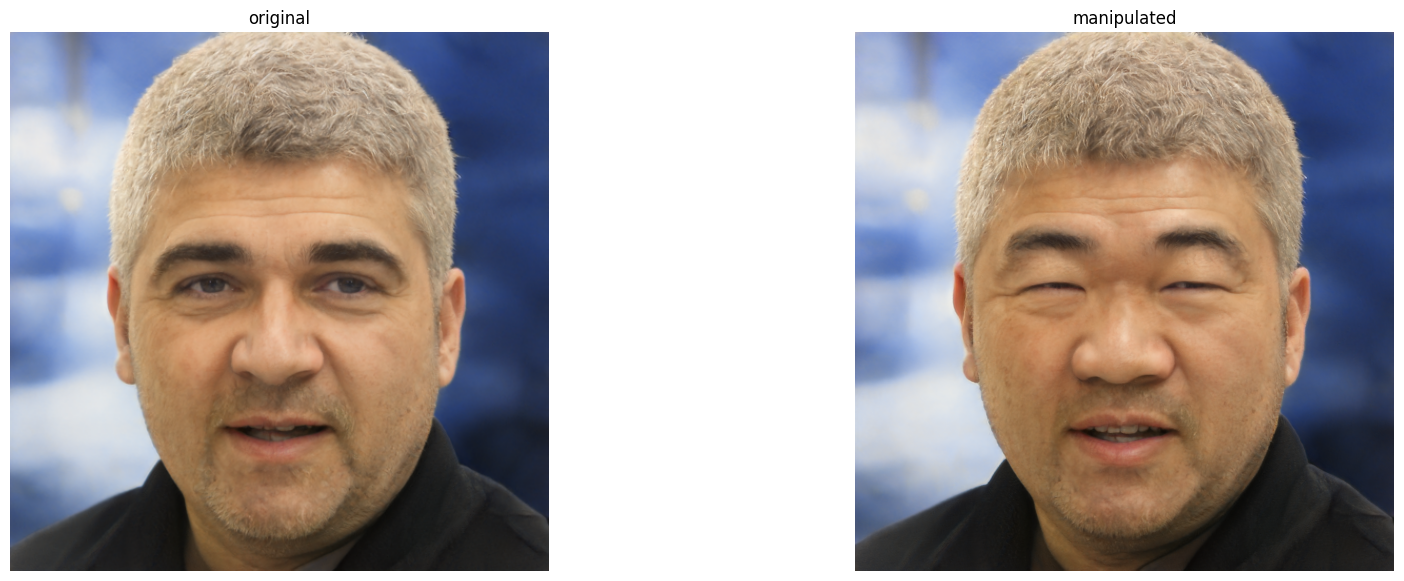

In [ ]:

#beta=0.1
#alpha=1
beta = 0.1 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 3.1 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

In [ ]:
# @title define function to save the result

import cv2

save_name = "" #@param {type: "string"}
save_path = image_dir + save_name

generated.save(save_path)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


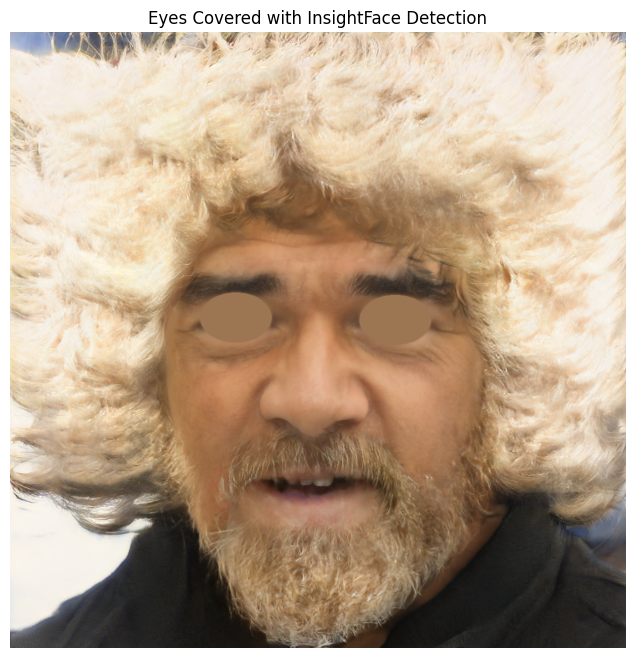

Number of faces detected: 1
Face 0: Left eye at [375.6153  474.82074], Right eye at [640.1     478.18124]


In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis

# Initialize InsightFace
app = FaceAnalysis(providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# Convert PIL image to numpy array
img = np.array(generated)
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Detect faces
faces = app.get(img_bgr)

for face in faces:
    # Get bounding box
    bbox = face.bbox.astype(int)

    # Sample skin color from forehead
    forehead_y1 = max(bbox[1], 0)
    forehead_y2 = max(bbox[1] + int((bbox[3] - bbox[1]) * 0.3), 0)
    forehead_x1 = max(bbox[0], 0)
    forehead_x2 = min(bbox[2], img_bgr.shape[1])

    skin_sample = img_bgr[forehead_y1:forehead_y2, forehead_x1:forehead_x2]

    if skin_sample.size > 0:
        skin_color = tuple(int(c) for c in np.mean(skin_sample.reshape(-1, 3), axis=0))
    else:
        skin_color = (189, 224, 255)

    # Use the 5 key points (2 eyes, nose, 2 mouth corners)
    if hasattr(face, 'kps'):
        landmarks = face.kps
        left_eye = landmarks[0]
        right_eye = landmarks[1]

        # Calculate eye size based on inter-eye distance
        eye_distance = np.linalg.norm(right_eye - left_eye)
        eye_width = int(eye_distance * 0.45)
        eye_height = int(eye_width * 0.7)

        # Draw ellipses over both eyes
        for eye_center in [left_eye, right_eye]:
            center = (int(eye_center[0]), int(eye_center[1]))
            axes = (eye_width // 2, eye_height // 2)

            # Draw the ellipse
            cv2.ellipse(img_bgr, center, axes, 0, 0, 360, skin_color, -1)

            # Add some blur around the edges for better blending
            mask = np.zeros(img_bgr.shape[:2], dtype=np.uint8)
            cv2.ellipse(mask, center, axes, 0, 0, 360, 255, -1)

            # Create a slightly larger mask for blurring
            blur_mask = np.zeros(img_bgr.shape[:2], dtype=np.uint8)
            blur_axes = (int(axes[0] * 1.2), int(axes[1] * 1.2))
            cv2.ellipse(blur_mask, center, blur_axes, 0, 0, 360, 255, -1)

            # Blur the edge region
            edge_mask = cv2.bitwise_xor(blur_mask, mask)
            blurred = cv2.GaussianBlur(img_bgr, (15, 15), 0)
            img_bgr = np.where(edge_mask[..., None] > 0, blurred, img_bgr)

# Convert back to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
masked_image = Image.fromarray(img_rgb)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(masked_image)
plt.axis('off')
plt.title('Eyes Covered with InsightFace Detection')
plt.show()

# Debug: Show detected eye positions
print(f"Number of faces detected: {len(faces)}")
for i, face in enumerate(faces):
    if hasattr(face, 'kps'):
        print(f"Face {i}: Left eye at {face.kps[0]}, Right eye at {face.kps[1]}")

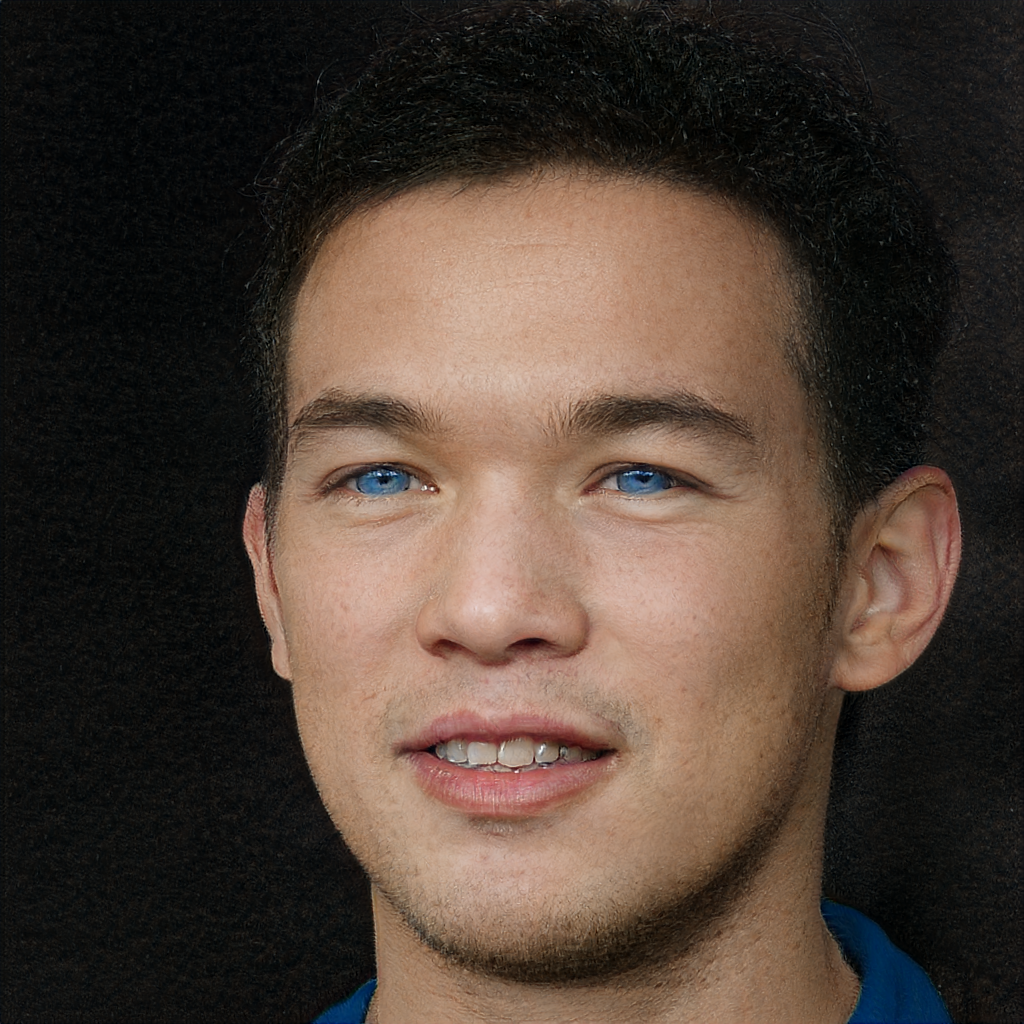

In [ ]:
#@title generate a high-res manipulated photo for download
generated

# video

Renders a video interpolating from the base image with provided `beta` to the `target_alpha`. (`target_alpha` can be positive or negative)

In [ ]:
from contextlib import contextmanager
import sys, os
from tqdm.notebook import tqdm

beta =  0.15 #@param {type:"number"}
target_alpha =  4.1#@param {type:"number"}
num_frames = 350 #@param {type:"number"}
frame_rate = 60 #@param {type:"number"}

!rm -rf /content/results
!mkdir /content/results

# Mute GetBoundary()
# https://stackoverflow.com/a/25061573
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def gen_image(beta, alpha, i):
  M.alpha=[alpha]
  with suppress_stdout():
    boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
  codes=M.MSCode(dlatent_tmp,boundary_tmp2)
  out=M.GenerateImg(codes)
  Image.fromarray(out[0,0]).save(f"/content/results/{i:04d}.png")

alphas = np.linspace(0, target_alpha, num_frames)

print("Generating Frames:")
for i, alpha in tqdm(enumerate(alphas), total=num_frames):
  gen_image(beta, alpha, i)

print("Rendering Video...")
result = os.system(f"ffmpeg -y -r {frame_rate} -i /content/results/%04d.png -c:v libx264 -vf fps={frame_rate} -pix_fmt yuv420p /content/styleclip.mp4")
print("Video saved at styleclip.mp4!")

from google.colab import files
files.download('/content/styleclip.mp4')

Generating Frames:


  0%|          | 0/350 [00:00<?, ?it/s]

Rendering Video...
Video saved at styleclip.mp4!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>